In [7]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import random

In [13]:
def norm(mu, var, statsnorm=False):
    """
    gives the coordinates required to plot a normal distribution given the parameters provided.
    
    Input:
    >>> mu  -> the mean of the distribution
    >>> var -> the variance of the distribution
    >>> statsnorm -> to caluclate using stats.norm.pdf or not
    
    Output:
    >>> x  -> the x values of the distribution (within 4 s.ds of the mean)
    >>> y2 -> the y values calculated explicitly
    >>> y  -> the y values calculated using stats.norm
    """
    
    sigma = math.sqrt(var)
    x = np.linspace(mu-6*sigma, mu +6 *sigma, 300)
    
    if statsnorm:
        y = stats.norm.pdf(x, mu, sigma)
    else:
        y = [np.exp(-1/2*((i-mu)/sigma)**2)/ (sigma*np.sqrt(2 * np.pi)) for i in x]
    return x, y

def ROCFrom2NormalDistributions(mu1, var1, mu2, var2,printAUC=False):
    """
    plots the ROC curve given by two normal distributions, parameters given here. Assuming that mu1 <= mu2.
    That mu1 corresponds to non-diseased and mu2 to diseased.
    
    Input:
    >>> mu1  -> mean of first distribution
    >>> var1 -> varaince of first distribution
    >>> mu2  -> mean of second distribution
    >>> var2 -> varaince of second distribution
    
    Output:
    >>> TPF  -> list of true positive values calculated by averages
    >>> FPF  -> list of false positive values calculated by averages
    >>> t    -> list of uniform false positive fractions
    >>> TPF2 -> list of uniform true positive fractions
    """
    # Calculate distribution parameters
    norm1x, norm1y = norm(mu1, var1)
    norm2x, norm2y = norm(mu2, var2)
    
    sigma1 = np.sqrt(var1)
    sigma2 = np.sqrt(var2)
    
    # Find ROC = (t,ROC(t)) and print AUC as the average (uniform) TPF
    a = (mu1-mu2)/sigma2
    b = sigma1/sigma2
    
    t = np.linspace(0,1,101)
    TPF2 = [1-stats.norm.cdf(a + b * stats.norm.ppf(1-i)) for i in t]
    
    #print(np.sum(TPF2)/len(TPF2))
    
    # Find ROC by finding TPF and FPF - Result 4.7 Pepe
    fullxs = (np.concatenate((norm1x, norm2x)))
    x = np.linspace(min(fullxs), max(fullxs), 100)
    
    FPF = [1-stats.norm.cdf(i, mu1, sigma1) for i in x]
    TPF = [1-stats.norm.cdf(i, mu2, sigma2) for i in x]
      
    AUC = stats.norm.cdf(-a/(np.sqrt(1+b**2)),0,1)
    #print(f'AUC for curve with ({mu1},{var1},{mu2},{var2}): {AUC}')

    return TPF, FPF, t, TPF2

In [22]:
diabetes_data = np.loadtxt('C:/Mark/uni/Uni Work/5th Year/Diss/Coding ROC Curves in Python Diabetes/DiabetesData.csv',
                       dtype=float,
                       delimiter=',',
                       skiprows=1)

# Create healthy and diseased segements of the data
yh = diabetes_data[diabetes_data[:,1] == 0]
yd = diabetes_data[diabetes_data[:,1] == 1]

yh = yh[yh[:,2] >= 27]
yh = yh[yh[:,2] <= 78]

yd = yd[yd[:,2] >= 27]
yd = yd[yd[:,2] <= 78]

yh = np.log(yh[:,0])
yd = np.log(yd[:,0])
#aged30 = diabetes_data[diabetes_data[:,2] == 23]

In [34]:
def bootstrap_confidence_intervals_normal(n, data, upperpctCI=0.975, lowerpctCI=0.025, log = True):
    """
    The function takes data and fits n normal rocs, then plots the estimate empirical ROC, the 97.5% and 2.5% from
    the boostrapped ROCs.
    
    Input:
    >>> n          number of bootstrapped sample empirical ROCs
    >>> data       Data in the form of a numpy array with first column marker values and second column disease status
    >>> upperpctCI Lower quantile of the bootstraps to take as the CI
    >>> lowerpctCI Upper quantile of the bootstraps to take as the CI 
    >>> log        Makes a log transform of the data if True
    
    Output:     
    >>> result  Dictionary with the keys 'upperCI', 'lowerCI' that has the corresponding 
                ROC (in [[FPFs], [TPFs], [AUC]]) as values. Where FPFs is a grid of 100 values and TPFs the corresponding
                100 TPFs. AUC is a float value of the area under the curves
    """
    
    data_len = len(data)
    
    AUCs = []
    ROCs = []

    for _ in range(n):
        random_data = np.array([data[random.randint(0, data_len-1)] for _ in range(data_len)])

        yh = (random_data[random_data[:,1] == 0])
        yd = (random_data[random_data[:,1] == 1])
        
        if log:
            yh = np.log(yh[:,0])
            yd = np.log(yd[:,0])
            
        _,_,FPF, TPF = ROCFrom2NormalDistributions(np.mean(yh), np.var(yh), np.mean(yd), np.var(yd), printAUC=False)

        ROCs.append([FPF, TPF])

    # Now we have constructed each of the ROCs
    
    FPFgrid = np.linspace(0,1,100)
    ROCs = np.array(ROCs)
    FPFs, TPFs = ROCs[:,0], ROCs[:,1]
    t_prev = 0

    TPF975s = []
    TPF25s = []
    TPFs_now = []

    # For each region of the grid...
    for t in FPFgrid:

        # For each ROC curve ... 
        for j in range(n):
            # Let's find all the FPFs that are lower than t
            indexes = []

            # This is all indexes that have an FPF between t and t-1
            for i in range(100):
                if FPFs[j,i] < t and FPFs[j,i] >= t_prev:
                    indexes.append(i)

            # This is all the FPFs corresponding to those indexes
            for ind in indexes:
                TPFs_now.append(TPFs[j,ind])

        # Find the correct quantiles of the corresponding TPFs
        TPF975 = stats.mstats.mquantiles(TPFs_now, upperpctCI)
        TPF25 = stats.mstats.mquantiles(TPFs_now, lowerpctCI)

        # Append them to the lists of quantiles
        TPF975s.append(TPF975)
        TPF25s.append(TPF25)

        # Reset the TPFs now and the current quantiles
        TPFs_now = []
        TPF25 = []
        TPF975 = []

        # set this for [t_prev,t] so that t_prev=t-1
        t_prev = t
    
    result = {}
    
    result['upperCI'] = [[FPFgrid], [TPF975s],[np.sum(TPF975s)/len(TPF975s)]]
    result['lowerCI'] = [[FPFgrid], [TPF25s],[np.sum(TPF25s)/len(TPF25s)]]
    
    return result

res = bootstrap_confidence_intervals_normal(2000, diabetes_data, upperpctCI=0.975, lowerpctCI=0.025, log = True)

upperCI = res['upperCI']
lowerCI = res['lowerCI']

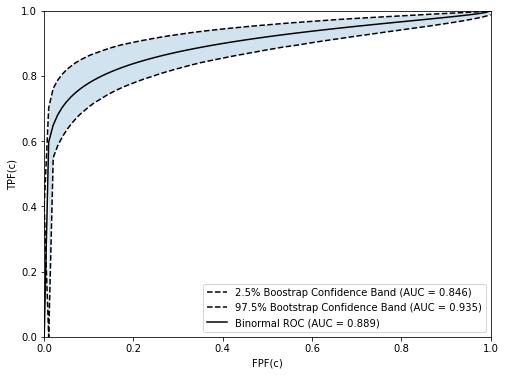

In [37]:
plt.figure(figsize=(8,6)) 
plt.plot(lowerCI[0][0], lowerCI[1][0], 'k--', label=f'2.5% Boostrap Confidence Band (AUC = {round(lowerCI[2][0],3)})')
plt.plot(upperCI[0][0], upperCI[1][0], 'k--', label=f'97.5% Bootstrap Confidence Band (AUC = {round(upperCI[2][0],3)})')

mu = np.mean(yh)
sigma = np.std(yh)

mu2 = np.mean(yd)
sigma2 = np.std(yd)
_, _, FPF, TPF = ROCFrom2NormalDistributions(mu, sigma**2, mu2, sigma2**2, printAUC=True)

plt.plot(FPF, TPF, 'k-', label=f'Binormal ROC (AUC = {round(np.mean(TPF), 3)})')

plt.fill_between(lowerCI[0][0][1:], [i[0] for i in upperCI[1][0][1:]], [i[0] for i in lowerCI[1][0][1:]], alpha=0.2)
plt.xlim(0,1)
plt.ylim(0,1)

legend=True

if legend:
    plt.legend()

plt.xlabel("FPF(c)")
plt.ylabel("TPF(c)")
plt.show()
